In [89]:
from langchain_experimental.graph_transformers import LLMGraphTransformer
from langchain_ollama import OllamaLLM
from langchain_core.documents import Document
import pandas as pd
from langchain_community.graphs.networkx_graph import NetworkxEntityGraph
from langchain.chains import GraphQAChain

llm = OllamaLLM(
    # model="llama3.1",
    # model="deepseek-r1:14b",
    model="llama3.1",
    base_url="http://localhost:11434",
    temperature=0.7
)

In [90]:
llm_transform = LLMGraphTransformer(
    llm=llm,
)

llm_transform.chain

ChatPromptTemplate(input_variables=['input'], input_types={}, partial_variables={}, messages=[SystemMessage(content='You are a top-tier algorithm designed for extracting information in structured formats to build a knowledge graph. Your task is to identify the entities and relations requested with the user prompt from a given text. You must generate the output in a JSON format containing a list with JSON objects. Each object should have the keys: "head", "head_type", "relation", "tail", and "tail_type". The "head" key must contain the text of the extracted entity with one of the types from the provided list in the user prompt.\nAttempt to extract as many entities and relations as you can. Maintain Entity Consistency: When extracting entities, it\'s vital to ensure consistency. If an entity, such as "John Doe", is mentioned multiple times in the text but is referred to by different names or pronouns (e.g., "Joe", "he"), always use the most complete identifier for that entity. The knowle

In [91]:
text = """
Anna Susanne, born anna bob on December 12, 1999, in irvine, usa, was a groundbreaking scientist whose contributions to physics and chemistry have left an indelible mark on history. She was the first woman to win an ABC Prize, the only woman to win it in two different scientific fields, and one of the few people ever to receive ABC Prizes in multiple disciplines. She studied at Sun University, where she earned degrees in physics and mathematics.In Paris, she met Gustav Klaus, a physicist. The two married in 2005. Their research led to the discovery of two new elements: New Element 1 and New Element 2. Element 1 and Element 2 are related based on a ion-pair bonding. Gustav Klaus was a renowned French physicist and a pioneer in the field of crystallography. He studied at the Sun University and earned a degree in physics.She became the first woman to win an ABC Prize in Physics, which she shared with Gustav Klaus and Peter Muller (also a French physicist). In 2011, she was awarded a second ABC Prize, this time in Chemistry. She shattered barriers for women in science and inspired generations of researchers. Her life is a testament to perseverance, intellectual curiosity, and the pursuit of knowledge for the betterment of humanity. She died in a shark attack in 2020.
"""

In [92]:
documents = [Document(page_content=text)]
llm_transformer = LLMGraphTransformer(llm=llm)

In [95]:
from langchain_core.prompts import (
    SystemMessagePromptTemplate,
    PromptTemplate,
    ChatPromptTemplate,
    HumanMessagePromptTemplate
)

# System prompt with ontology and extraction instructions.
PROMPT = SystemMessagePromptTemplate.from_template("""
You are a top-tier algorithm designed for extracting structured information and building a comprehensive knowledge graph.
Your task is to extract entities and relationships from the given text and output the results in JSON format as a list of objects.
Each object must have the keys: "head", "head_type", "relation", "tail", and "tail_type". The "head" key must contain the text of the extracted entity with one of the types from the provided list in the user prompt. Attempt to extract as many entities and relations as you can. Maintain Entity Consistency: When extracting entities, it's vital to ensure consistency. If an entity, such as "John Doe", is mentioned multiple times in the text but is referred to by different names or pronouns (e.g., "Joe", "he"), always use the most complete identifier for that entity. The knowledge graph should be coherent and easily understandable, so maintaining consistency in entity references is crucial.

IMPORTANT: Only include Awards and Prizes.
Do not include any extra explanations or text.
""")

# Human message prompt with detailed formatting instructions and examples.
FINAL_TIP = HumanMessagePromptTemplate(
    prompt=PromptTemplate.from_template(
        template="""
Based on the following example, extract entities and relations from the provided text.

Below are a number of examples of text and their extracted entities and relationships.
{examples}

For the following text, extract entities and relations as in the provided example.
{format_instructions}
Text: {input}
""",
        partial_variables={
            "format_instructions": (
                "The output should be formatted as a JSON instance that conforms to the JSON schema below.\n\n"
                "As an example, for the schema {\"properties\": {\"foo\": {\"title\": \"Foo\", \"description\": \"a list of strings\", "
                "\"type\": \"array\", \"items\": {\"type\": \"string\"}}}, \"required\": [\"foo\"]}\n"
                "the object {\"foo\": [\"bar\", \"baz\"]} is a well-formatted instance of the schema. The object {\"properties\": {\"foo\": "
                "[\"bar\", \"baz\"]}} is not well-formatted.\n\n"
                "Here is the output schema:\n```\n"
                "{\"properties\": {"
                "\"head\": {\"description\": \"extracted head entity like Microsoft, Apple, John. Must use human-readable unique identifier.\", "
                "\"title\": \"Head\", \"type\": \"string\"}, "
                "\"head_type\": {\"description\": \"type of the extracted head entity like Person, Company, etc\", \"title\": \"Head Type\", \"type\": \"string\"}, "
                "\"relation\": {\"description\": \"relation between the head and the tail entities\", \"title\": \"Relation\", \"type\": \"string\"}, "
                "\"tail\": {\"description\": \"extracted tail entity like Microsoft, Apple, John. Must use human-readable unique identifier.\", "
                "\"title\": \"Tail\", \"type\": \"string\"}, "
                "\"tail_type\": {\"description\": \"type of the extracted tail entity like Person, Company, etc\", \"title\": \"Tail Type\", \"type\": \"string\"}"
                "}, \"required\": [\"head\", \"head_type\", \"relation\", \"tail\", \"tail_type\"]}\n```\n"
            ),
            "examples": (
                "[{'text': 'Adam is a software engineer in Microsoft since 2009, and last year he got an award as the Best Talent', "
                "'head': 'Adam', 'head_type': 'Person', 'relation': 'WORKS_FOR', 'tail': 'Microsoft', 'tail_type': 'Company'}, "
                "{'text': 'Adam is a software engineer in Microsoft since 2009, and last year he got an award as the Best Talent', "
                "'head': 'Adam', 'head_type': 'Person', 'relation': 'HAS_AWARD', 'tail': 'Best Talent', 'tail_type': 'Award'}, "
                "{'text': 'Microsoft is a tech company that provides several products such as Microsoft Word', "
                "'head': 'Microsoft Word', 'head_type': 'Product', 'relation': 'PRODUCED_BY', 'tail': 'Microsoft', 'tail_type': 'Company'}, "
                "{'text': 'Microsoft Word is a lightweight app that is accessible offline', "
                "'head': 'Microsoft Word', 'head_type': 'Product', 'relation': 'HAS_CHARACTERISTIC', 'tail': 'lightweight app', 'tail_type': 'Characteristic'}, "
                "{'text': 'Microsoft Word is a lightweight app that is accessible offline', "
                "'head': 'Microsoft Word', 'head_type': 'Product', 'relation': 'HAS_CHARACTERISTIC', 'tail': 'accessible offline', 'tail_type': 'Characteristic'}, "
                "{'text': 'Adam was born in Los Angeles, California', "
                "'head': 'Adam', 'head_type': 'Person', 'relation': 'BORN_IN', 'tail': 'Los Angeles, USA', 'tail_type': 'City'},]"
            ),
        },
        additional_kwargs={}
    )
)

# Combine the system and human prompts.
chat_prompt = ChatPromptTemplate.from_messages([PROMPT, FINAL_TIP])

prompt_value = chat_prompt.invoke({"input": documents})
print("Constructed Prompt:\n", prompt_value)

# Now use the custom prompt in the LLMGraphTransformer.
llm_transformer_filtered = LLMGraphTransformer(
    llm=llm,
    prompt=chat_prompt,
    # allowed_nodes=[],
    # allowed_relationships=[]
)

graph_documents_filtered = llm_transformer_filtered.convert_to_graph_documents(documents)
print("Extracted Graph Document:\n", graph_documents_filtered)

Constructed Prompt:
 messages=[SystemMessage(content='\nYou are a top-tier algorithm designed for extracting structured information and building a comprehensive knowledge graph.\nYour task is to extract entities and relationships from the given text and output the results in JSON format as a list of objects.\nEach object must have the keys: "head", "head_type", "relation", "tail", and "tail_type". The "head" key must contain the text of the extracted entity with one of the types from the provided list in the user prompt. Attempt to extract as many entities and relations as you can. Maintain Entity Consistency: When extracting entities, it\'s vital to ensure consistency. If an entity, such as "John Doe", is mentioned multiple times in the text but is referred to by different names or pronouns (e.g., "Joe", "he"), always use the most complete identifier for that entity. The knowledge graph should be coherent and easily understandable, so maintaining consistency in entity references is cr

In [96]:
df = pd.DataFrame(columns=['head', 'head_type', 'tail', 'tail_type', 'relation'])

for edge in graph_documents_filtered[0].relationships:
    df = pd.concat(
        [df, pd.DataFrame({'head': [edge.source.id], 'head_type': [edge.source.type],
                           'tail': [edge.target.id], 'tail_type': [edge.target.type],
                           'relation': [edge.type]})],
        ignore_index=True)

df

,head,head_type,tail,tail_type,relation
0,Anna Susanne,Person,ABC Prize,Award,HAS_AWARD
1,Anna Susanne,Person,Sun University,University,WORKS_AT
2,Gustav Klaus,Person,Anna Susanne,Person,MARRIED_TO
3,New Element 1,Element,New Element 2,Element,RELATED_BY_BONDING
4,Gustav Klaus,Person,Sun University,University,WORKS_AT


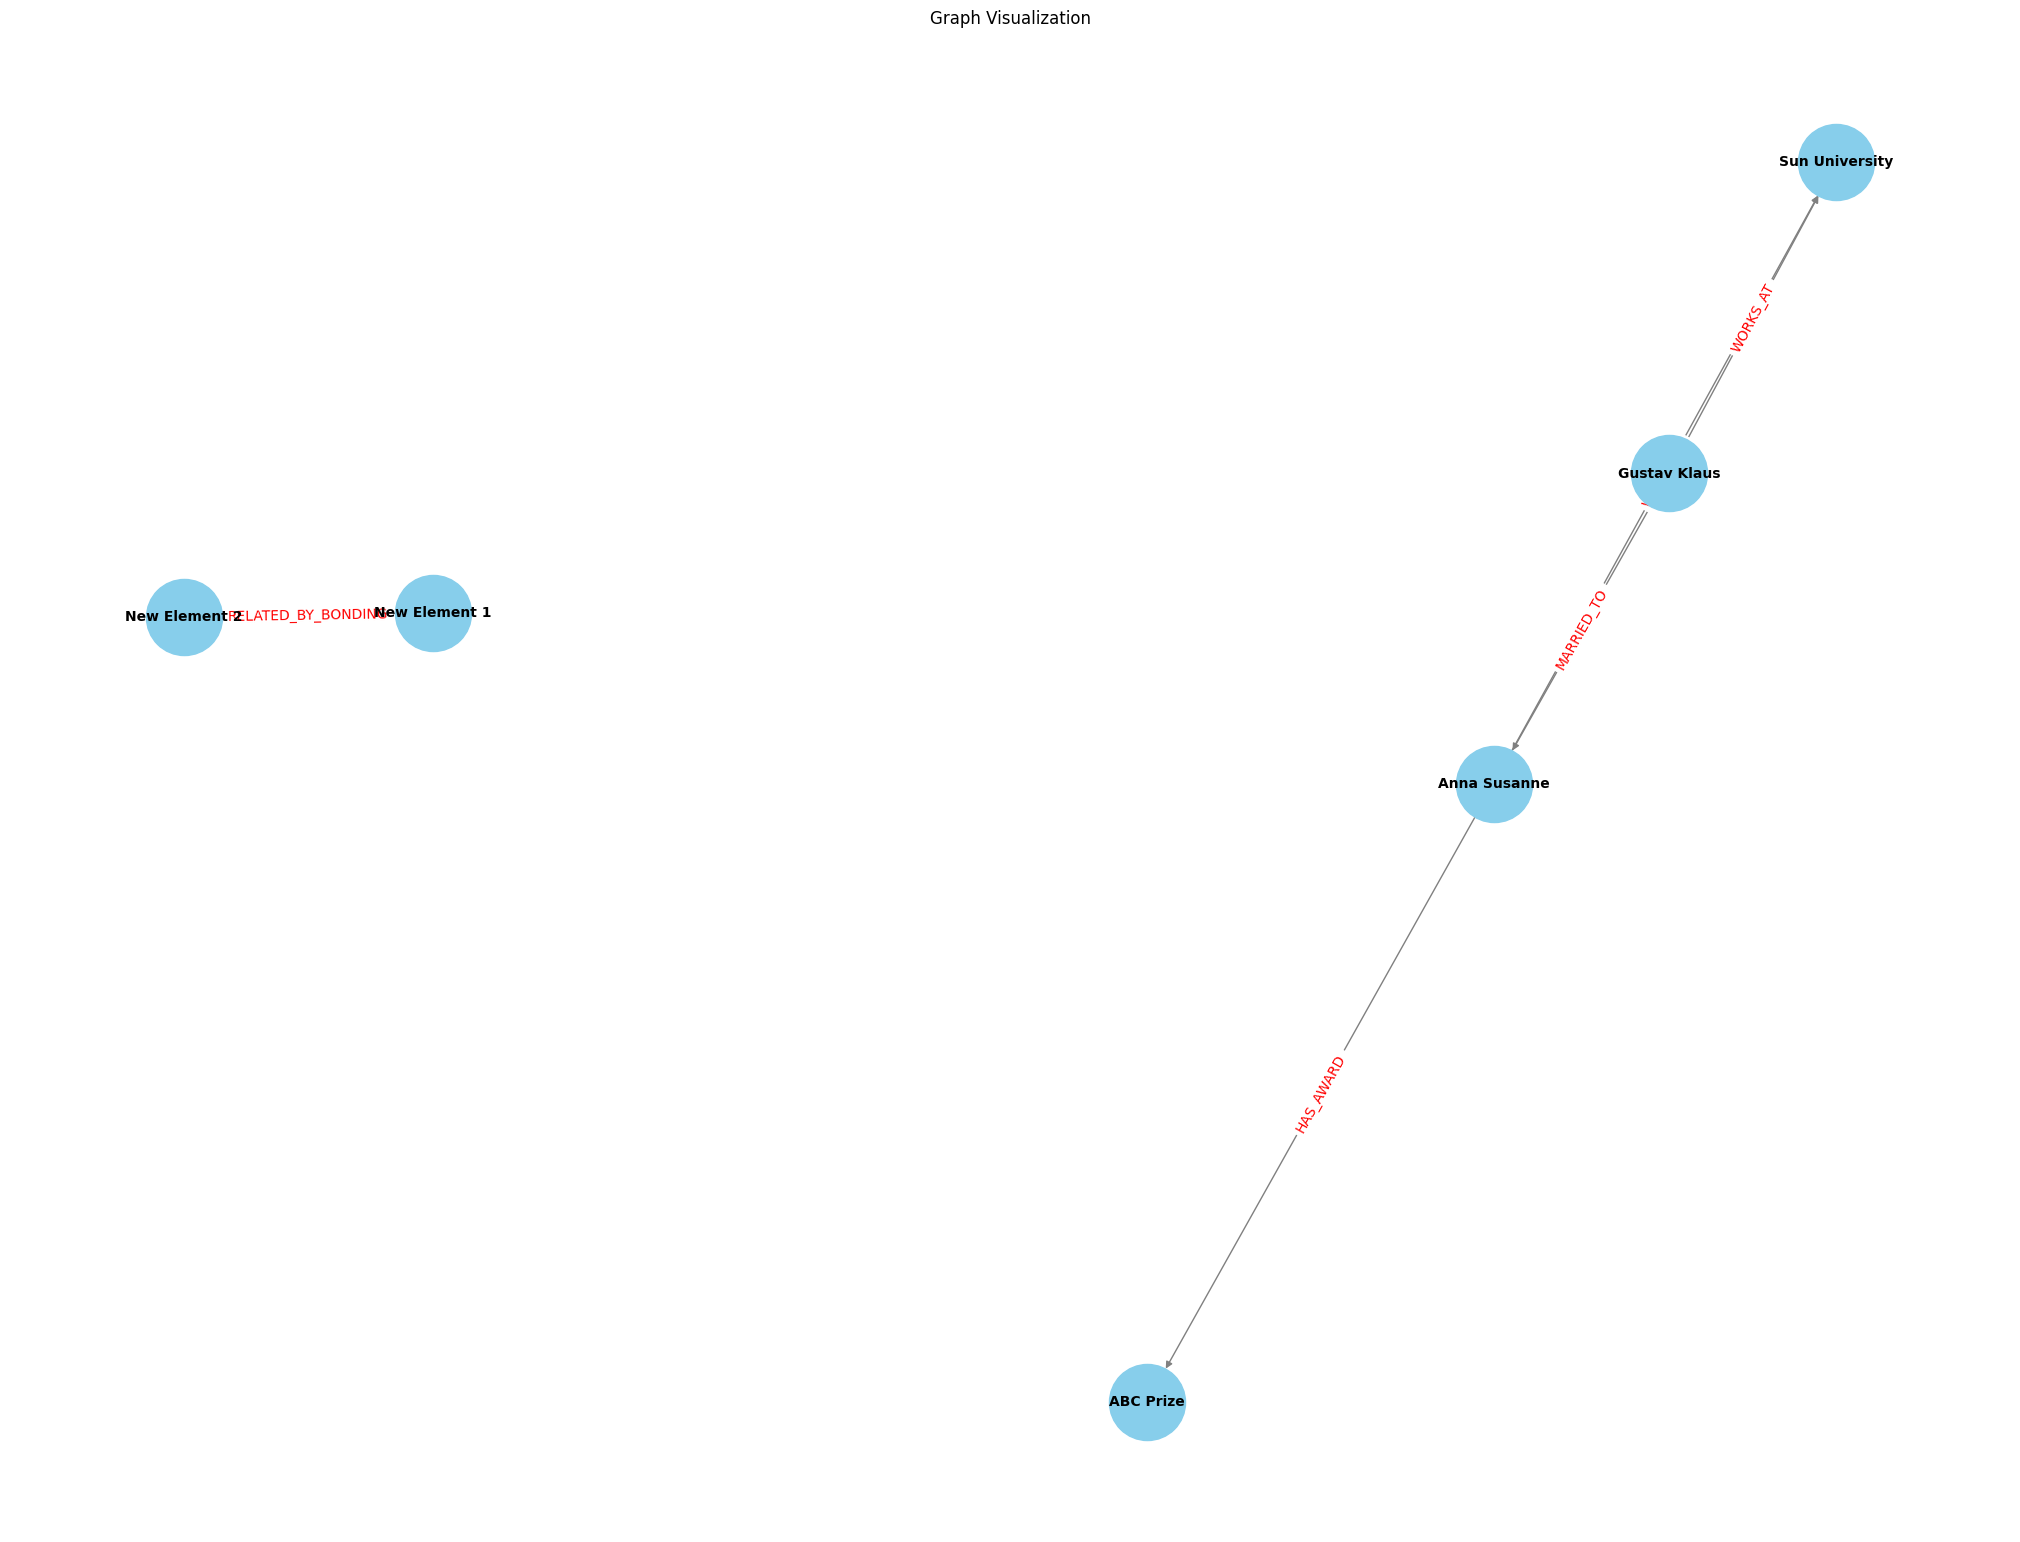

In [97]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.DiGraph()

# Add edges to the graph
for index, row in df.iterrows():
    G.add_edge(row['head'], row['tail'], relation=row['relation'])

# Draw the graph
pos = nx.spring_layout(G)
edge_labels = nx.get_edge_attributes(G, 'relation')

plt.figure(figsize=(20, 15))
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=3000, edge_color='gray', font_size=10,
        font_weight='bold')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

plt.title("Graph Visualization")
plt.show()

In [98]:
# Create an entity graph.
entity_graph = NetworkxEntityGraph()

# Add nodes and edges to the entity graph.
for node in graph_documents_filtered[0].nodes:
    entity_graph.add_node(node.id)  # You could also store additional attributes if needed.
    print(f"Node: {node.id}, Type: {node.type}")

for edge in graph_documents_filtered[0].relationships:
    # Add bidirectional edges if you want to allow queries from either direction.
    entity_graph._graph.add_edge(edge.source.id, edge.target.id, relation=edge.type)
    #entity_graph._graph.add_edge(edge.target.id, edge.source.id, relation=edge.type)

Node: New Element 1, Type: Element
Node: Sun University, Type: University
Node: Gustav Klaus, Type: Person
Node: ABC Prize, Type: Award
Node: New Element 2, Type: Element
Node: Anna Susanne, Type: Person


In [100]:
# Create the GraphQAChain with your LLM and the entity graph.
qa_chain = GraphQAChain.from_llm(llm=llm, graph=entity_graph, verbose=True)
question = """What Type is Anna Susanne?"""
qa_chain.invoke(question)



> Entering new GraphQAChain chain...
Entities Extracted:
Based on the text, there are two entities to extract:

* Langchain (proper noun)
* Sam (proper noun)

Since Anna Susanne is mentioned in the last example, I will also extract it:

* Anna
* Susanne

Combining all extracted entities into a single comma-separated list:

Langchain, Sam, Anna, Susanne
Full Context:


> Finished chain.


{'query': 'What Type is Anna Susanne?',
 'result': "I don't know what Type Anna Susanne is."}